### Step 1: load and scale features

In [4]:
DATASET_FOLDER = "v1.5"
TYPE = "cleaned-pbc"
SPLITS = ["train", "val", "test"]

In [5]:
import torch

train_features = torch.load("v1.5_cleaned-pbc_llfs/train.pt", weights_only=True).numpy()

In [6]:
"""standardize features (mean=0, std=1)"""

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)

### Step 2: fit PCA on scaled features

In [7]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(train_features_scaled)
print("explained variance ratio for scaled features:", pca.explained_variance_ratio_)

explained variance ratio for scaled features: [0.46025902 0.05524161]


In [8]:
import os
import ase.io


def get_pca(split, features, pca, scaler):
    features_scaled = scaler.transform(features.cpu().numpy())
    transformed = pca.transform(features_scaled)

    # group by subsets
    feature_index = 0
    subset_results = {}

    for root, _dirs, _files in os.walk(DATASET_FOLDER):
        xyz_path = os.path.join(root, TYPE, f"{split}.xyz")
        if not os.path.exists(xyz_path):
            continue

        subset_name = os.path.basename(root)
        structures = ase.io.read(xyz_path, ":")
        n_structures = len(structures)
        subset_results[subset_name] = transformed[
            feature_index : feature_index + n_structures
        ]
        feature_index += n_structures

    return subset_results

In [9]:
def predict(split, scaler, subset_weights):
    feats = torch.load(f"v1.5_cleaned-pbc_llfs/{split}.pt", weights_only=True)
    feats_scaled = scaler.transform(feats.numpy())

    res = {}
    for root, _dirs, _files in os.walk(DATASET_FOLDER):
        xyz_path = os.path.join(root, TYPE, f"{split}.xyz")
        if not os.path.exists(xyz_path):
            continue

        subset_name = os.path.basename(root)
        structures = ase.io.read(xyz_path, ":")
        n_structures = len(structures)

        if subset_name in subset_weights:
            subset_features = feats_scaled[:n_structures]
            feats_scaled = feats_scaled[n_structures:]
            W = subset_weights[subset_name].numpy()
            pca_pred = subset_features @ W
            res[subset_name] = pca_pred

    return res

### calculate W for subsets

In [10]:
train_subset_results = get_pca("train", torch.from_numpy(train_features), pca, scaler)

# fit regression weights
subset_weights = {}
for subset_name, subset_pca_values in train_subset_results.items():
    subset_features = train_features_scaled[: len(subset_pca_values)]
    train_features_scaled = train_features_scaled[len(subset_pca_values) :]
    W = torch.linalg.lstsq(
        torch.tensor(subset_features, dtype=torch.float32),
        torch.tensor(subset_pca_values, dtype=torch.float32),
    ).solution
    subset_weights[subset_name] = W

### predict PCA

In [11]:
predicted_pca_test = predict("test", scaler, subset_weights)

### compare with calculated PCA

In [12]:
test_features = torch.load("v1.5_cleaned-pbc_llfs/test.pt", weights_only=True)
test_features_scaled = scaler.transform(test_features.numpy())
actual_pca_test = get_pca("test", test_features, pca, scaler)

In [ ]:
predicted_pca_val = predict("val", scaler, subset_weights)
val_features = torch.load("v1.5_cleaned-pbc_llfs/val.pt", weights_only=True)
val_features_scaled = scaler.transform(val_features.numpy())
actual_pca_test = get_pca("val", val_features, pca, scaler)

### evaluate

In [13]:
import numpy as np
from sklearn.metrics import (
    mean_absolute_error,
    explained_variance_score,
)
from scipy.spatial.distance import cosine


def compute_metrics(actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    cos_sim = 1 - cosine(actual.flatten(), predicted.flatten())
    var_score = explained_variance_score(actual, predicted)
    return {"mae": mae, "cosine similarity": cos_sim, "var_score": var_score}


def eval(pred_dict, ground_truth_dict):
    all_actual = np.concatenate(list(ground_truth_dict.values()))
    all_predicted = np.concatenate(
        [v.numpy() if isinstance(v, torch.Tensor) else v for v in pred_dict.values()]
    )
    return compute_metrics(all_actual, all_predicted)

In [14]:
eval_test = eval(predicted_pca_test, actual_pca_test)
print(eval_test)

{'mae': 0.013122169, 'cosine similarity': 0.9999824431524093, 'var_score': 0.9998440146446228}


### visualisation

In [15]:
import matplotlib.pyplot as plt


def plot_pca_by_subsets(subset_results, title="train"):
    plt.figure(figsize=(6, 4))

    num_subsets = len(subset_results)
    colors = plt.cm.tab20(np.linspace(0, 1, num_subsets))

    for i, (subset_name, features) in enumerate(subset_results.items()):

        plt.scatter(
            features[:, 0],
            features[:, 1],
            color=colors[i],
            label=subset_name,
            alpha=0.6,
            edgecolors="w",
            s=50,
        )

    plt.title(title)
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.grid(alpha=0.3)

    plt.legend(
        bbox_to_anchor=(1.0, 1), loc="upper left", borderaxespad=0.0, frameon=False
    )

    plt.tight_layout()
    plt.show()

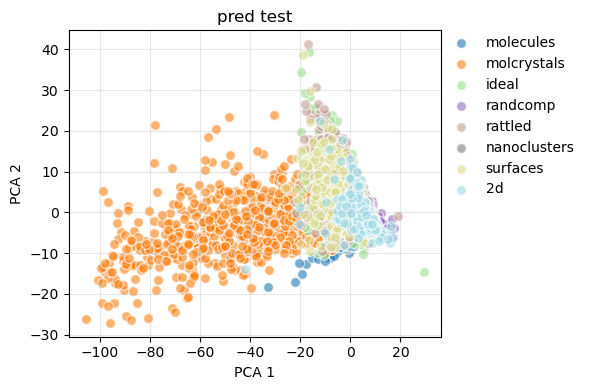

In [16]:
plot_pca_by_subsets(predicted_pca_test, "pred test")

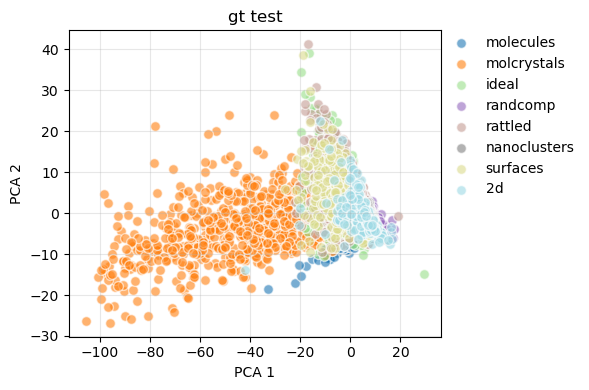

In [17]:
plot_pca_by_subsets(actual_pca_test, "gt test")

In [22]:
import matplotlib.image as mpimg


def compare_images(imagepath1, imagepath2, eval_res):
    image1 = mpimg.imread(imagepath1)
    image2 = mpimg.imread(imagepath2)

    _fig, axes = plt.subplots(1, 2, figsize=(12, 8))

    axes[0].imshow(image1)
    axes[0].axis("off")

    axes[1].imshow(image2)
    axes[1].axis("off")

    title = ", ".join(f"{metric}: {val:.5f}" for metric, val in eval_res.items())

    plt.suptitle(title, y=0.75)

    plt.tight_layout()
    plt.show()

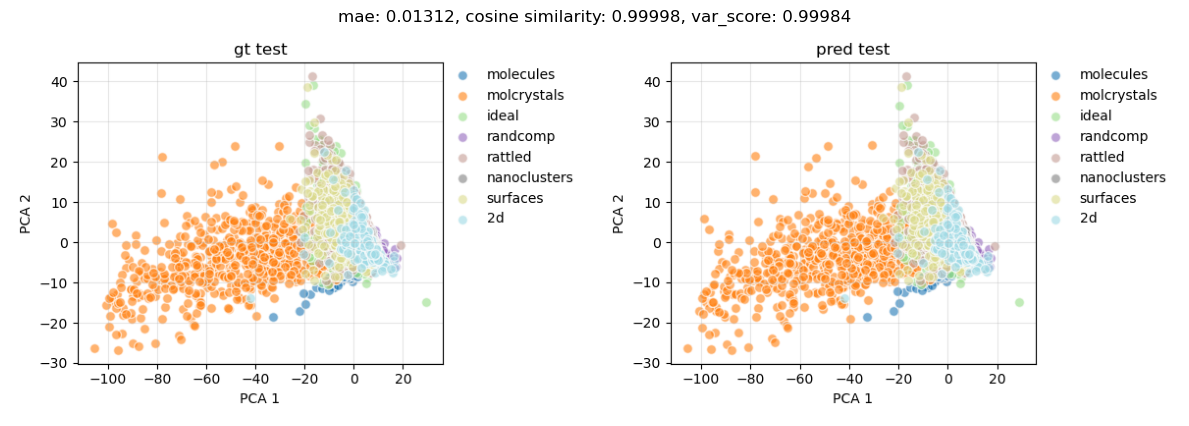

In [23]:
compare_images("test_gt.png", "test_pred.png", eval_test)